In [17]:
%matplotlib inline
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from SAMPEX_functions import read_counts as read
from SAMPEX_functions import mb_finder, mb_magnitude, iso_calculator, OrbAtt_augment, OrbAtt_augment_loop
import pandas as pd
import os
import pathlib
import string

In [18]:
# defining file
year = '1993'
start_day = '1'
end_day = '365'
Output_Plots = False

In [19]:
# code is specific for year 1993
OrbAtt_names = np.array(['OrbAtt_secofyear_1993001-1993012.txt', 'OrbAtt_secofyear_1993013-1993039.txt', 'OrbAtt_secofyear_1993040-1993066.txt', \
                         'OrbAtt_secofyear_1993067-1993093.txt', 'OrbAtt_secofyear_1993094-1993120.txt', 'OrbAtt_secofyear_1993121-1993147.txt', \
                         'OrbAtt_secofyear_1993148-1993174.txt', 'OrbAtt_secofyear_1993175-1993201.txt', 'OrbAtt_secofyear_1993202-1993228.txt', \
                         'OrbAtt_secofyear_1993229-1993255.txt', 'OrbAtt_secofyear_1993256-1993282.txt', 'OrbAtt_secofyear_1993283-1993309.txt', \
                         'OrbAtt_secofyear_1993310-1993336.txt', 'OrbAtt_secofyear_1993337-1993363.txt', 'OrbAtt_secofyear_1993364-1993365.txt'])

In [20]:
directory = 'E:\SAMPEX_Data\\' + year + '_data\\'
for i in np.arange(len(OrbAtt_names)):
    OA_file = OrbAtt_names[i]
    OrbAtt_file = pd.read_csv(directory + OA_file, names = ['day', 'hr', 'min', 'sec', 'GEO_Radius', 'GEO_Long', 'GEO_Lat', 'Altitude', 
                                                        'L_Shell', 'MLT', 'SAA_Flag', 'Pitch', 'zenith', 'azimuth', 'Att_Flag'], sep = '\s+', header = 70)

In [21]:
########### INITIALIZING MB & BG ISO vs PARAM HISTOGRAMS ############
max_iso = 1.0
bin_num = 25

iso_bins = np.linspace(0, max_iso, num=bin_num+1)

mag_bins = np.linspace(0, 33000, num=bin_num+1)
MLT_bins = np.linspace(0, 24, num=bin_num+1)
PA_bins = np.linspace(0, 180, num=bin_num+1)
L_bins = np.linspace(3, 8, num=bin_num+1)

###### MICROBURST ISO vs PARAMETERS #######
# Create empty microburst histograms
H_IvMag_MB, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[mag_bins, iso_bins])
H_IvMLT_MB, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[MLT_bins, iso_bins])
H_IvPA_MB, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[PA_bins, iso_bins])
H_IvL_MB, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[L_bins, iso_bins])

###### BACKGROUND ISO vs PARAMETERS #######
# Create empty background histograms
H_IvMag_BG, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[mag_bins, iso_bins])
H_IvMLT_BG, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[MLT_bins, iso_bins])
H_IvPA_BG, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[PA_bins, iso_bins])
H_IvL_BG, _, _ = np.histogram2d(np.array([]), np.array([]), bins=[L_bins, iso_bins])

In [22]:
for day_of_year in np.arange(int(start_day), int(end_day)+1):
    # name the day
    if len(str(day_of_year)) == 1:
        file = 'hhrr' + year + '00' + str(day_of_year) + '.txt'
    elif len(str(day_of_year)) == 2:
        file = 'hhrr' + year + '0' + str(day_of_year) + '.txt'
    elif len(str(day_of_year)) == 3:
        file = 'hhrr' + year + str(day_of_year) + '.txt'

    # reading in electron counts files:
    t_electrons, r1, r2, r3, r4 = read(year + '_data\\' + file)

    # reading in orbit/attitude data file
    OrbAtt_mask = []
    for i in np.arange(len(OrbAtt_names)):
        OrbAtt_mask.append(day_of_year >= int(OrbAtt_names[i][21:24]) and day_of_year <= int(OrbAtt_names[i][29:32]))
        
    OA_file = OrbAtt_names[OrbAtt_mask][0]
    
    directory = 'E:\SAMPEX_Data\\' + year + '_data\\'
    OrbAtt_file = pd.read_csv(directory + OA_file, names = ['day', 'hr', 'min', 'sec', 'GEO_Radius', 'GEO_Long', 'GEO_Lat', 'Altitude', 
                                                            'L_Shell', 'MLT', 'SAA_Flag', 'Pitch', 'zenith', 'azimuth', 'Att_Flag'], sep = '\s+', header = 70)
    
    # Augment OrbAtt data to fit counts data
    t_OrbAtt, LS_OrbAtt, MLT_OrbAtt, P_OrbAtt, Lat_OrbAtt, Long_OrbAtt, R_OrbAtt, t_electrons, r1, r2, r3, r4 = OrbAtt_augment_loop(t_electrons, r1, r2, r3, r4, OrbAtt_file, day_of_year)


    ############## mask for spatial/temporal regions ##############
    
    mask = np.abs(90 - P_OrbAtt) >= 50
    t_OrbAtt = t_OrbAtt[mask]; LS_OrbAtt = LS_OrbAtt[mask]; MLT_OrbAtt = MLT_OrbAtt[mask];
    P_OrbAtt = P_OrbAtt[mask]; Lat_OrbAtt = Lat_OrbAtt[mask]; Long_OrbAtt = Long_OrbAtt[mask];
    R_OrbAtt = R_OrbAtt[mask]; t_electrons = t_electrons[mask]; r1 = r1[mask]; r2 = r2[mask]; r3 = r3[mask]; r4 = r4[mask]

    ###############################################################
    
    
    # find microburst times and N_100, SSD1, SSD4 counts using algorithm
    t_microburst, N_100_microburst, r1_microburst, r4_microburst, mb_index, MB_mask, N_100, A_500 = mb_finder(t_electrons, r1, r2, r3, r4)

    # create background counts mask
    BG_mask = ~MB_mask

    # calculation of the isotropy indices of electron counts
    iso_indices_MB = iso_calculator(r1[MB_mask], r4[MB_mask])
    iso_indices_BG = iso_calculator(r1[BG_mask], r4[BG_mask])

    # find the OrbAtt microburst parameters
    if len(mb_index) > 0:
        t_OrbAtt_mb = t_OrbAtt[mb_index]; LS_OrbAtt_mb = LS_OrbAtt[mb_index]; MLT_OrbAtt_mb = MLT_OrbAtt[mb_index];
        P_OrbAtt_mb = P_OrbAtt[mb_index]; Lat_OrbAtt_mb = Lat_OrbAtt[mb_index]; Long_OrbAtt_mb = Long_OrbAtt[mb_index];
        R_OrbAtt_mb = R_OrbAtt[mb_index]

    # calculation of B_3 bin percentiles
    y_microburst, B_3_microburst, B_3 = mb_magnitude(N_100, N_100_microburst, A_500)
    
    ### COUNTS TO FLUX CONVERT ###
    y_microburst = counts2flux(y_microburst)
    
    y = N_100 - B_3
    y_background = y[BG_mask]   
    
    ###### MICROBURST ISO vs PARAMETERS #######
    # Create histograms for day #
    if len(mb_index) > 0:
        
        H_IvMag_MB_day, _, _ = np.histogram2d(y_microburst, iso_indices_MB, bins=[mag_bins, iso_bins])
        H_IvMLT_MB_day, _, _ = np.histogram2d(MLT_OrbAtt_mb, iso_indices_MB, bins=[MLT_bins, iso_bins])
        H_IvPA_MB_day, _, _ = np.histogram2d(P_OrbAtt_mb, iso_indices_MB, bins=[PA_bins, iso_bins])
        H_IvL_MB_day, _, _ = np.histogram2d(LS_OrbAtt_mb, iso_indices_MB, bins=[L_bins, iso_bins])
    
        # Add histograms for day # to cumulative histograms
        H_IvMag_MB += H_IvMag_MB_day
        H_IvMLT_MB += H_IvMLT_MB_day
        H_IvPA_MB += H_IvPA_MB_day
        H_IvL_MB += H_IvL_MB_day
    
    ###### BACKGROUND ISO vs PARAMETERS #######
    # Create histograms for day #
    H_IvMag_BG_day, _, _ = np.histogram2d(y_background, iso_indices_BG, bins=[mag_bins, iso_bins])
    H_IvMLT_BG_day, _, _ = np.histogram2d(MLT_OrbAtt[BG_mask], iso_indices_BG, bins=[MLT_bins, iso_bins])
    H_IvPA_BG_day, _, _ = np.histogram2d(P_OrbAtt[BG_mask], iso_indices_BG, bins=[PA_bins, iso_bins])
    H_IvL_BG_day, _, _ = np.histogram2d(LS_OrbAtt[BG_mask], iso_indices_BG, bins=[L_bins, iso_bins])
    
    # Add histograms for day # to cumulative histograms
    H_IvMag_BG += H_IvMag_BG_day
    H_IvMLT_BG += H_IvMLT_BG_day
    H_IvPA_BG += H_IvPA_BG_day
    H_IvL_BG += H_IvL_BG_day

In [23]:
print(file)

hhrr1993365.txt


In [24]:
print(np.sum(H_IvMag_MB==0))
print(np.sum(H_IvMag_MB!=0))
print(H_IvMag_MB.shape[0])

for i in np.arange(H_IvMag_MB.shape[0]):
    for j in np.arange(H_IvMag_MB.shape[1]):
        if H_IvMag_MB[i,j] == 0:
            H_IvMag_MB[i,j] = 1e-1


266
359
25


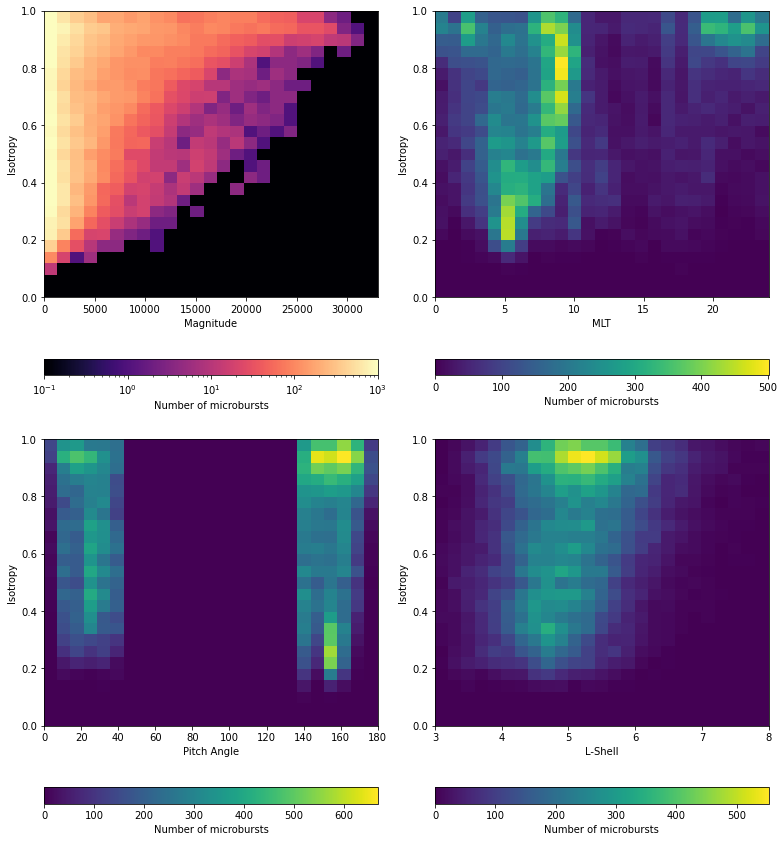

In [25]:
###### MICROBURST ISO vs PARAMETERS #######
# Make the four plots.
_, ax = plt.subplots(2, 2, figsize=(11, 12))

# convert zeros to 1e-1 to plot in log
for i in np.arange(H_IvMag_MB.shape[0]):
    for j in np.arange(H_IvMag_MB.shape[1]):
        if H_IvMag_MB[i,j] == 0:
            H_IvMag_MB[i,j] = 1e-1

p_IvMag_MB = ax[0,0].pcolormesh(mag_bins, iso_bins, H_IvMag_MB.T, cmap='magma', norm=colors.LogNorm(vmin=1e-1, vmax=1000))
plt.colorbar(p_IvMag_MB, ax=ax[0,0], orientation='horizontal', label='Number of microbursts')
ax[0,0].set_xlabel('Magnitude')
ax[0,0].set_ylabel('Isotropy')

p_IvMLT_MB = ax[0,1].pcolormesh(MLT_bins, iso_bins, H_IvMLT_MB.T, vmin=0)
plt.colorbar(p_IvMLT_MB, ax=ax[0,1], orientation='horizontal', label='Number of microbursts')
ax[0,1].set_xlabel('MLT')
ax[0,1].set_ylabel('Isotropy')

p_IvPA_MB = ax[1,0].pcolormesh(PA_bins, iso_bins, H_IvPA_MB.T, vmin=0)
plt.colorbar(p_IvPA_MB, ax=ax[1,0], orientation='horizontal', label='Number of microbursts')
ax[1,0].set_xlabel('Pitch Angle')
ax[1,0].set_ylabel('Isotropy')

p_IvL_MB = ax[1,1].pcolormesh(L_bins, iso_bins, H_IvL_MB.T, vmin=0)
plt.colorbar(p_IvL_MB, ax=ax[1,1], orientation='horizontal', label='Number of microbursts')
ax[1,1].set_xlabel('L-Shell')
ax[1,1].set_ylabel('Isotropy')

plt.tight_layout()
plt.show()

In [26]:
# counts units = [counts/100ms]
def counts2flux(counts):
    ms2s = 1/1000
    geo_factor = 15
    flux = (counts/100)*(1/ms2s)*(1/geo_factor)
    
    return flux

In [27]:
print(mag_bins)
print(counts2flux(mag_bins))
print(counts2flux(48000))

mag_bins = np.linspace(0, 32000, num=bin_num+1)

[    0.  1320.  2640.  3960.  5280.  6600.  7920.  9240. 10560. 11880.
 13200. 14520. 15840. 17160. 18480. 19800. 21120. 22440. 23760. 25080.
 26400. 27720. 29040. 30360. 31680. 33000.]
[    0.   880.  1760.  2640.  3520.  4400.  5280.  6160.  7040.  7920.
  8800.  9680. 10560. 11440. 12320. 13200. 14080. 14960. 15840. 16720.
 17600. 18480. 19360. 20240. 21120. 22000.]
32000.0


Text(0, 0.5, 'Isotropy Index')

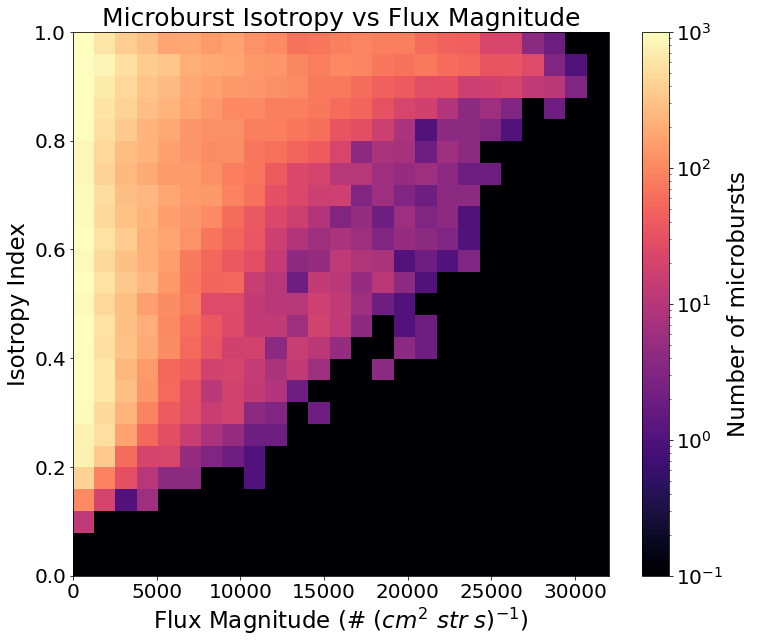

In [28]:
import matplotlib.ticker as mticker
# plot IvMag_MB for report
plt.figure(figsize = (12,10))
plt.title(f'Microburst Isotropy vs Flux Magnitude', fontsize = 25)
p_IvMag_MB = plt.pcolormesh(mag_bins, iso_bins, H_IvMag_MB.T, cmap='magma', norm=colors.LogNorm(vmin=1e-1, vmax=1000))
cb = plt.colorbar(p_IvMag_MB, pad = 0.05, orientation='vertical')
cb.set_label(label='Number of microbursts', size = 23)
cb.ax.tick_params(labelsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Flux Magnitude (# $(cm^2$ $str$ $s)^{-1}$)', fontsize = 23)
#ax = plt.gca()
#f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
#g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
#ax.xaxis.set_major_formatter(mticker.FuncFormatter(g))

plt.ylabel('Isotropy Index', fontsize = 23)

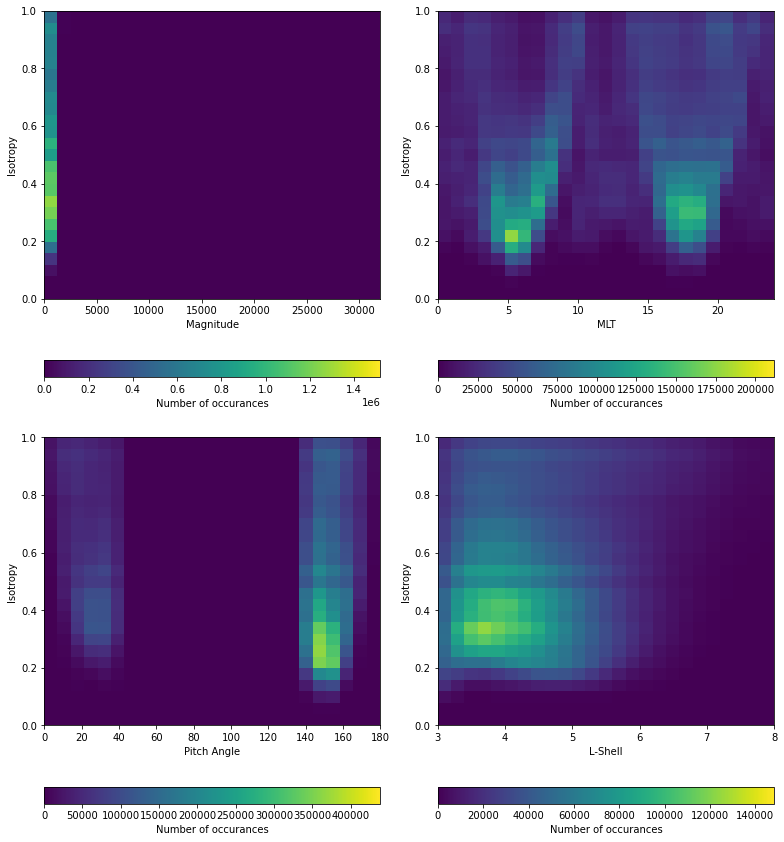

In [29]:
###### BACKGROUND ISO vs PARAMETERS #######
# Make the four plots.
_, ax = plt.subplots(2, 2, figsize=(11, 12))

p_IvMag_BG = ax[0,0].pcolormesh(mag_bins, iso_bins, H_IvMag_BG.T, vmin=0, vmax=np.max(H_IvMag_BG)*1.2)
plt.colorbar(p_IvMag_BG, ax=ax[0,0], orientation='horizontal', label='Number of occurances')
ax[0,0].set_xlabel('Magnitude')
ax[0,0].set_ylabel('Isotropy')

p_IvMLT_BG = ax[0,1].pcolormesh(MLT_bins, iso_bins, H_IvMLT_BG.T, vmin=0, vmax=np.max(H_IvMLT_BG)*1.2)
plt.colorbar(p_IvMLT_BG, ax=ax[0,1], orientation='horizontal', label='Number of occurances')
ax[0,1].set_xlabel('MLT')
ax[0,1].set_ylabel('Isotropy')

p_IvPA_BG = ax[1,0].pcolormesh(PA_bins, iso_bins, H_IvPA_BG.T, vmin=0, vmax=np.max(H_IvPA_BG)*1.2)
plt.colorbar(p_IvPA_BG, ax=ax[1,0], orientation='horizontal', label='Number of occurances')
ax[1,0].set_xlabel('Pitch Angle')
ax[1,0].set_ylabel('Isotropy')

p_IvL_BG = ax[1,1].pcolormesh(L_bins, iso_bins, H_IvL_BG.T, vmin=0, vmax=np.max(H_IvL_BG)*1.2)
plt.colorbar(p_IvL_BG, ax=ax[1,1], orientation='horizontal', label='Number of occurances')
ax[1,1].set_xlabel('L-Shell')
ax[1,1].set_ylabel('Isotropy')

plt.tight_layout()
plt.show()

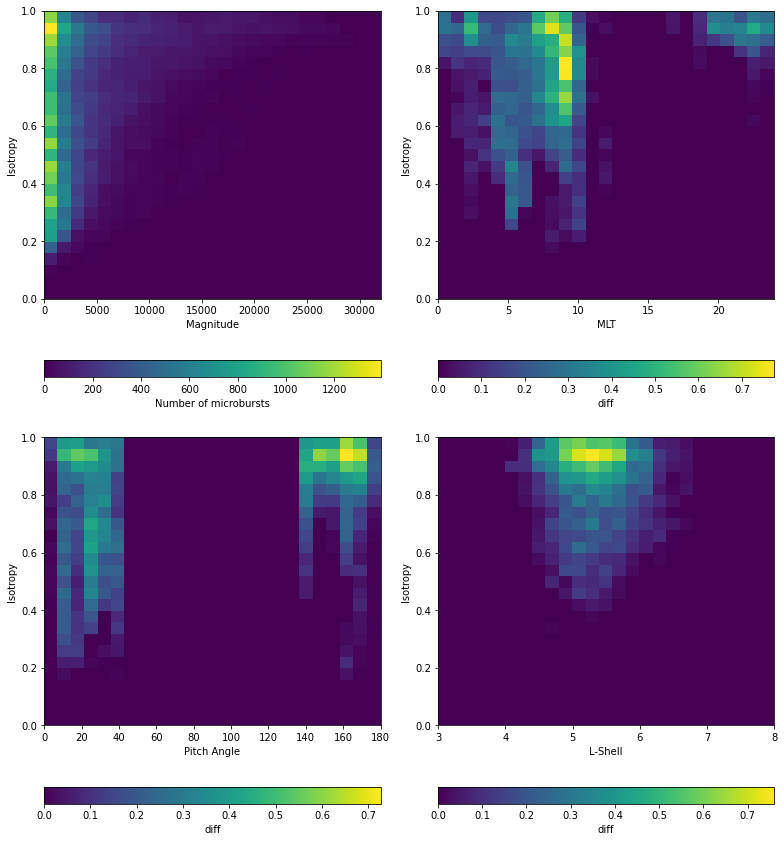

In [30]:
#diff_MLT = H_IvMLT_BG - H_IvMLT_MB
#diff_PA = H_IvPA_BG - H_IvPA_MB
#diff_L = H_IvL_BG - H_IvL_MB

diff_MLT = H_IvMLT_MB/np.max(H_IvMLT_MB) - H_IvMLT_BG/np.max(H_IvMLT_BG)
diff_PA = H_IvPA_MB/np.max(H_IvPA_MB) - H_IvPA_BG/np.max(H_IvPA_BG)
diff_L = H_IvL_MB/np.max(H_IvL_MB) - H_IvL_BG/np.max(H_IvL_BG)


_, ax = plt.subplots(2, 2, figsize=(11, 12))

p_IvMag_MB = ax[0,0].pcolormesh(mag_bins, iso_bins, H_IvMag_MB.T, vmin=0)
plt.colorbar(p_IvMag_MB, ax=ax[0,0], orientation='horizontal', label='Number of microbursts')
ax[0,0].set_xlabel('Magnitude')
ax[0,0].set_ylabel('Isotropy')

p_diff_MLT = ax[0,1].pcolormesh(MLT_bins, iso_bins, diff_MLT.T, vmin=0)
plt.colorbar(p_diff_MLT, ax=ax[0,1], orientation='horizontal', label='diff')
ax[0,1].set_xlabel('MLT')
ax[0,1].set_ylabel('Isotropy')

p_diff_PA = ax[1,0].pcolormesh(PA_bins, iso_bins, diff_PA.T, vmin=0)
plt.colorbar(p_diff_PA, ax=ax[1,0], orientation='horizontal', label='diff')
ax[1,0].set_xlabel('Pitch Angle')
ax[1,0].set_ylabel('Isotropy')

p_diff_L = ax[1,1].pcolormesh(L_bins, iso_bins, diff_L.T, vmin=0)
plt.colorbar(p_diff_L, ax=ax[1,1], orientation='horizontal', label='diff')
ax[1,1].set_xlabel('L-Shell')
ax[1,1].set_ylabel('Isotropy')

plt.tight_layout()
plt.show()